<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/StereoVOExample_large_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stereo Visual Odometry

A 3D stereo visual odometry example.

  - robot starts at origin
  - moves forward, taking periodic stereo measurements
  - takes stereo readings of many landmarks

In [1]:
%pip -q install gtbook # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gtsam
from gtsam import noiseModel, Pose3, StereoPoint2, Point3
import gtsam.utils.plot as gtsam_plot

## Load Stereo Rig Calibration

Just a regular pinhole calibration, plus a baseline, which in this case is 54 cm.

In [3]:
# read camera calibration info from file
# focal lengths fx, fy, skew s, principal point u0, v0, baseline b
calibration_loc = gtsam.findExampleDataFile("VO_calibration.txt")
fx, fy, s, u0, v0, b =np.loadtxt(calibration_loc)

# create stereo camera calibration object
K = gtsam.Cal3_S2Stereo(fx, fy, s, u0, v0, b)
print(f"focal length ~ {np.round(fx)}, baseline = {np.round(100*b)}cm")

focal length ~ 722.0, baseline = 54.0cm


## Load Camera Poses

We already have a very good initial estimate on file...

In [4]:
pose_loc = gtsam.findExampleDataFile("VO_camera_poses_large.txt")
pose_array = np.loadtxt(pose_loc)
initial_estimate = gtsam.Values()
for row in pose_array:
    initial_estimate.insert(gtsam.symbol('x', int(row[0])), Pose3(row[1:].reshape(4,4)))

## Create Factor Graph

We have about 8000 measurements, specified in a file as 8 numbers per row:

- i, j: pose and landmark indices
- uL, uR, v: the stereo measurement
- X, Y, Z: an initial estimate for the corresponding point $l_j$, resulting from triangulation

In [5]:
factor_loc = gtsam.findExampleDataFile("VO_stereo_factors_large.txt")
factor_array = np.loadtxt(factor_loc)

graph = gtsam.NonlinearFactorGraph ()
model = noiseModel.Isotropic.Sigma(3, 1) # 1 pixel standard deviation
for i, j, uL, uR, v, X, Y, Z in factor_array:
    measured = StereoPoint2(uL, uR, v)
    pose_key, point_key = gtsam.symbol('x', int(i)), gtsam.symbol('l', int(j))
    graph.add(gtsam.GenericStereoFactor3D(
        measured, model, pose_key, point_key, K))
    # if the landmark variable included in this factor has not yet been added
    # to the initial variable value estimate, add it
    if not initial_estimate.exists(point_key):
        wTc = initial_estimate.atPose3(pose_key)
        worldPoint = wTc.transformFrom(Point3(X, Y, Z))
        initial_estimate.insert(point_key, worldPoint)

## Batch Optimization

We constrain the first pose such that it cannot change from its original value during optimization.
NOTE: NonlinearEquality forces the optimizer to use QR rather than Cholesky QR is much slower than Cholesky, but numerically more stable.

In [6]:
first_pose = initial_estimate.atPose3(gtsam.symbol('x', 1))
graph.add(gtsam.NonlinearEqualityPose3(gtsam.symbol('x', 1), first_pose))

# create Levenberg-Marquardt optimizer to optimize the factor graph
params = gtsam.LevenbergMarquardtParams()
params.setOrderingType("METIS")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

Let us bring the first 3 poses:

In [9]:
for i in pose_array[:3,0]:
    pose_key = gtsam.symbol('x', int(i))
    print(result.atPose3(pose_key))

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0

R: [
	0.999997, -0.00234524, 0.000667659;
	0.00234572, 0.999997, -0.000714904;
	-0.000665981, 0.000716469, 1
]
t: 0.00254935 0.00430119   0.959176

R: [
	0.999993, -0.00363586, 0.000733503;
	0.00363353, 0.999988, 0.00316275;
	-0.000744993, -0.00316007, 0.999995
]
t: 0.00112241 0.00989265     1.9179



We can also plot the result (needs more work):

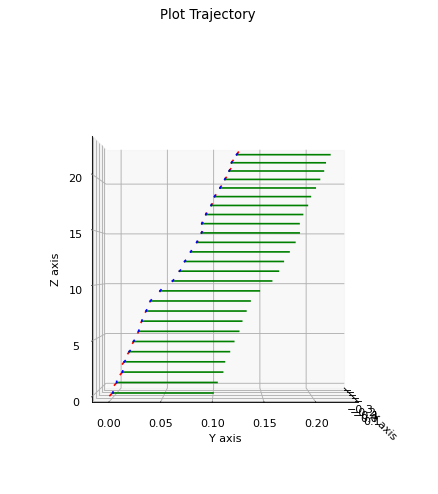

In [8]:
plt.figure(0, figsize=(12, 7), dpi=80)
gtsam_plot.plot_trajectory(0, result, scale=0.1)
plt.gca().view_init(0, 0)
plt.gca().set_box_aspect([1,1,1])